In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from datetime import datetime
import warnings
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import math
import random
from scipy.stats import t
import scipy.stats as st
import numpy as np
import collections
from numbers import Number
from __future__ import division
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 15, 6
use_colours = {0: "blue", 1: "red"}

In [265]:
df = pd.read_csv("fact_price_weekly_wmp.csv")

In [266]:
df.head()

,fact,year,month,yearmonth,date,geo,geo_partner,WMP,product_sk,product,product_code,unit,currency_sk,curr_value,lag_value,source
0,price,2016,11,201611,2016-11-05,NETHERLANDS,ns,WMP,1723,WMP,ns,EUR/kg,408954,2.6900,0,bordbia_dairy_price
1,price,2016,10,201610,2016-10-29,NETHERLANDS,ns,WMP,1723,WMP,ns,EUR/kg,408888,2.6700,0,bordbia_dairy_price
2,price,2016,10,201610,2016-10-22,NETHERLANDS,ns,WMP,1723,WMP,ns,EUR/kg,408822,2.6700,0,bordbia_dairy_price
3,price,2016,10,201610,2016-10-15,NETHERLANDS,ns,WMP,1723,WMP,ns,EUR/kg,408756,2.6700,0,bordbia_dairy_price
4,price,2016,10,201610,2016-10-08,UNITED STATES,ns,WMP,1723,WMP,ns,EUR/kg,408690,4.4411,0,bordbia_dairy_price


In [267]:
df.yearmonth = df.yearmonth.astype(str)

In [268]:
df["yearmonth"] = df.yearmonth.apply(lambda dates: datetime.strptime(dates, '%Y%m').strftime('%m/%Y'))

In [269]:
df['yearmonth'] = pd.to_datetime(df['yearmonth'])


In [270]:
#df = df.set_index("yearmonth")
df.curr_value = df.curr_value.fillna(np.mean(df.curr_value))

In [271]:
ts = df["curr_value"]

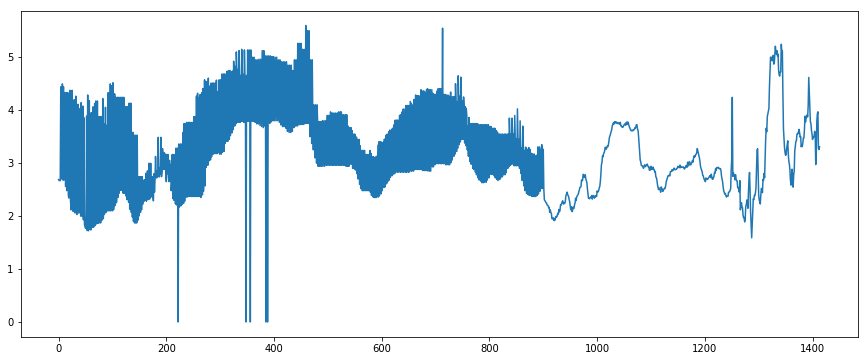

In [272]:
plt.plot(ts)


In [273]:
index = df.index.values

In [274]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

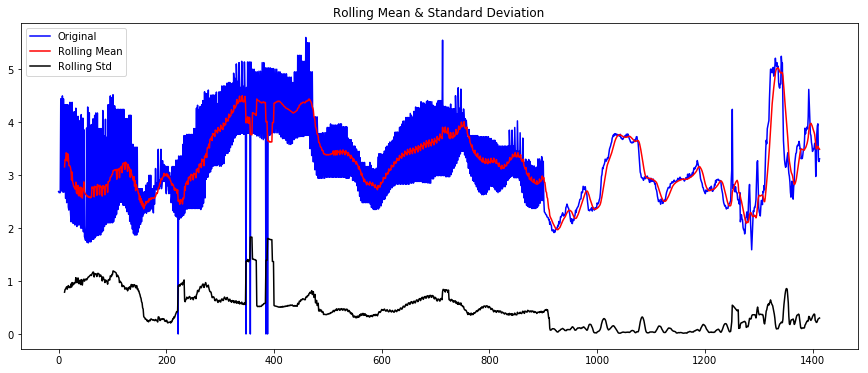

Results of Dickey-Fuller Test:
Test Statistic                   -3.622133
p-value                           0.005352
#Lags Used                       24.000000
Number of Observations Used    1389.000000
Critical Value (5%)              -2.863623
Critical Value (1%)              -3.435067
Critical Value (10%)             -2.567879
dtype: float64


In [275]:
test_stationarity(ts)

In [276]:
sd = np.std(df["curr_value"])
mean = np.mean(df["curr_value"])
# Upper Bound
X_upper = mean + sd*4
# Lower Bound
X_lower = mean - sd*4
rng = np.random.RandomState(42)

# Generate some abnormal novel observations
X_outliers_1 = rng.uniform(low=X_upper*0.9, high=X_upper*2, size=(50, 1))
X_outliers_2 = rng.uniform(low=-X_lower*1.5, high=-X_lower*2, size=(50, 1))

Outliers = []
Outliers.extend(X_outliers_1)
Outliers.extend(X_outliers_2)
df["Actual"] = False
idx = df.index
for i in Outliers:
    loc = np.random.randint(0, len(df))
    df.loc[loc,"curr_value"] = i
    df.loc[loc,"Actual"] = True

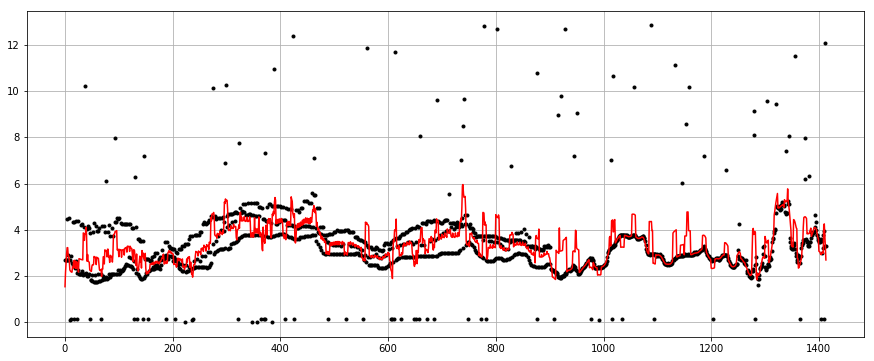

In [277]:
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

x = index
y = df.curr_value


plt.plot(x,y,"k.")
y_av = movingaverage(y, 7)
plt.plot(x, y_av,"r")
plt.grid(True)
plt.show()

std = np.std(y_av)
df["Events"] = False
ind = []
for i in range(len(df.curr_value)):
    if df["curr_value"][i] > y_av[i]+3*std:
        df.loc[i,"Events"] = True

In [278]:
cm=confusion_matrix(df.Actual,df.Events)

In [279]:
print("Accuracy of Moving Mean based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of Moving Mean based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Events)))

Accuracy of Moving Mean based Outlier detection without Autoencoders is :0.964639321075
Precision of Moving Mean based Outlier detection without Autoencoders is:0.484536082474
Cohen's Kappa: 0.636500118253


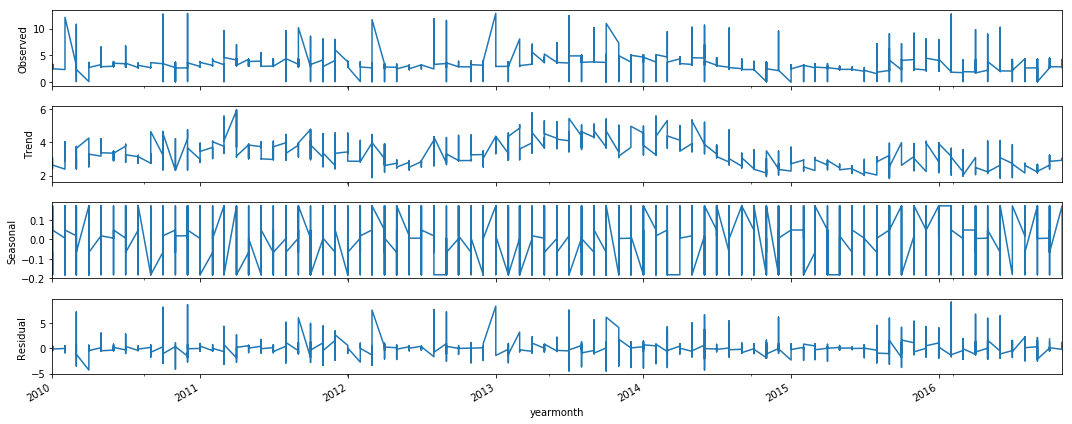

In [281]:
df = df.set_index("yearmonth")
res = sm.tsa.seasonal_decompose(df["curr_value"],freq=7)
resplot = res.plot()

In [282]:
random = res.resid
min_res = np.mean(random) - 3*np.std(random)
max_res = np.mean(random) + 3*np.std(random)

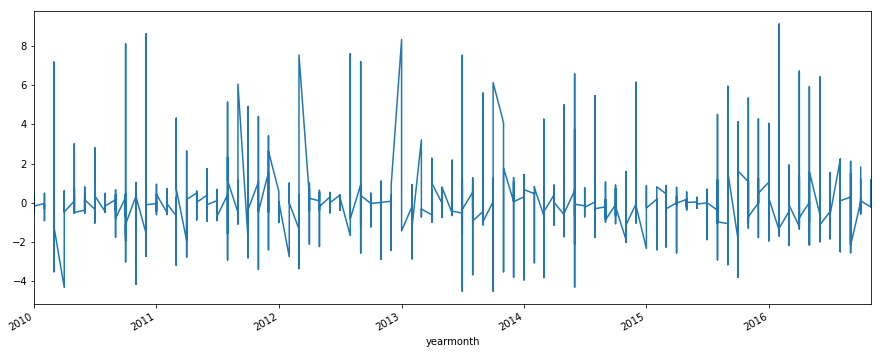

In [283]:
random.plot()

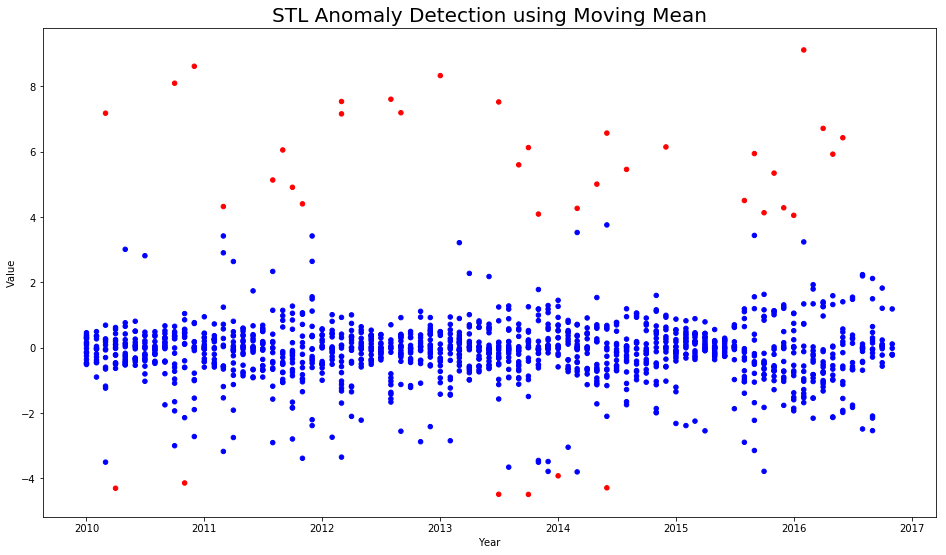

In [284]:
anomaly = []
for i in random:
    if i > max_res or i < min_res:
        anomaly.append(True)
    else:
        anomaly.append(False)

plt.figure(figsize=(16,9))
plt.scatter(random.index, random, c=[use_colours[x] for x in anomaly], s=20)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("STL Anomaly Detection using Moving Mean", fontsize="20")

In [285]:
def running_median_numpy(seq,window_size):
    data = np.array(seq, dtype=float)
    result = []
    for i in range(1, window_size):
        window = data[:i]
        result.append(np.median(window))
    for i in xrange(len(data)-window_size+1):
        window = data[i:i+window_size]
        result.append(np.median(window))
    return result

In [286]:
random_med = running_median_numpy(df.curr_value.values,7)

In [287]:
random_med = np.array(random_med)

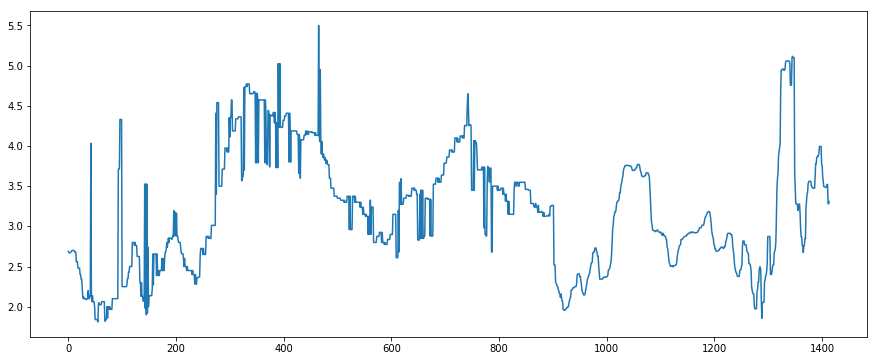

In [288]:
plt.plot(random_med)

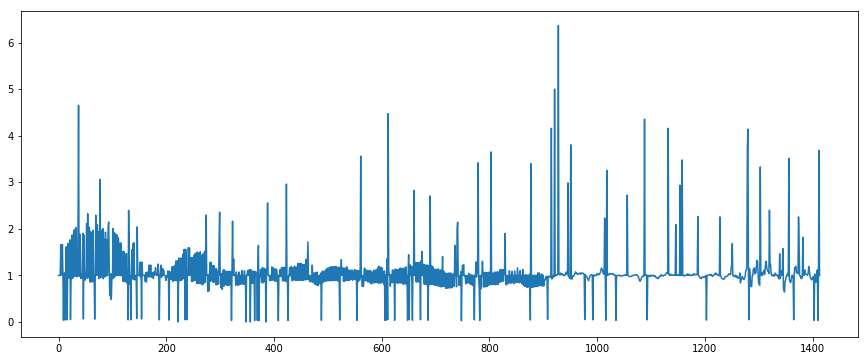

In [289]:
detrend_median = df.curr_value.values / random_med
plt.plot(detrend_median)

In [291]:
seasonal = np.mean(detrend_median)

In [292]:
random = df.curr_value.values / (random_med * seasonal)

In [293]:
detrend_median_wo_anom = running_median_numpy(random,3)
random = pd.DataFrame(random)

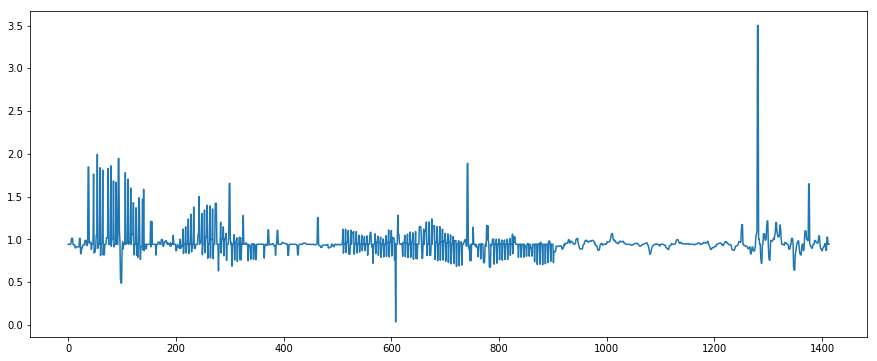

In [294]:
plt.plot(detrend_median_wo_anom)

In [300]:
min_res_med = np.mean(detrend_median_wo_anom) - 3*np.std(detrend_median_wo_anom)
max_res_med = np.mean(detrend_median_wo_anom) + 3*np.std(detrend_median_wo_anom)

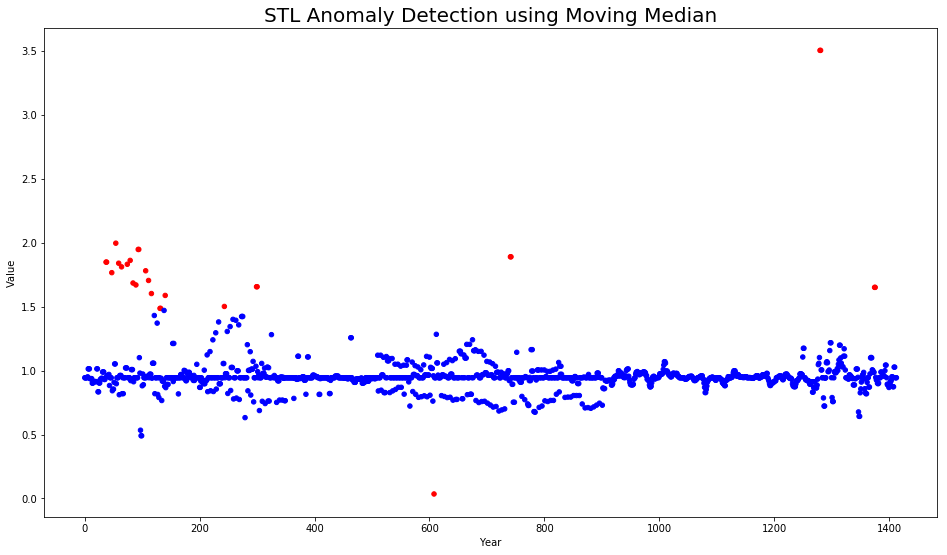

In [301]:
anomaly = []
for i in detrend_median_wo_anom:
    if i > max_res_med or i < min_res_med:
        anomaly.append(True)
    else:
        anomaly.append(False)

use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(random.index,detrend_median_wo_anom , c=[use_colours[x] for x in anomaly], s=20)
plt.xlabel('Year')
plt.ylabel('Value')
plt.title("STL Anomaly Detection using Moving Median", fontsize="20")

Since the p value is less than than the 5 % and 10 % critical value and very close to the 1 % level, the null hypothesis can be 
rejected and it can be concluded that the signal is stationary

In [158]:
df = df.reset_index()

In [159]:
df.head()

,yearmonth,fact,year,month,date,geo,geo_partner,WMP,product_sk,product,product_code,unit,currency_sk,curr_value,lag_value,source,Actual
0,2016-11-01,price,2016,11,2016-11-05,NETHERLANDS,ns,WMP,1723,WMP,ns,EUR/kg,408954,2.6900,0,bordbia_dairy_price,False
1,2016-10-01,price,2016,10,2016-10-29,NETHERLANDS,ns,WMP,1723,WMP,ns,EUR/kg,408888,2.6700,0,bordbia_dairy_price,False
2,2016-10-01,price,2016,10,2016-10-22,NETHERLANDS,ns,WMP,1723,WMP,ns,EUR/kg,408822,2.6700,0,bordbia_dairy_price,False
3,2016-10-01,price,2016,10,2016-10-15,NETHERLANDS,ns,WMP,1723,WMP,ns,EUR/kg,408756,2.6700,0,bordbia_dairy_price,False
4,2016-10-01,price,2016,10,2016-10-08,UNITED STATES,ns,WMP,1723,WMP,ns,EUR/kg,408690,4.4411,0,bordbia_dairy_price,False


In [160]:
print(df["product"].unique())
print(df["unit"].unique())
print(df["source"].unique())

['WMP']
['EUR/kg' 'USD/kg']
['bordbia_dairy_price' 'ec_europa_dairy_price'
 'zuivelnl_dutch_prices_weekly' 'global_dairy_trade_price']


As can be seen these features doesn't add any variance to the model, moreover id can also be neglected. only date,geo location and the curr_value are relevant features 

Label Encoding

In [161]:
df["geo"] = df["geo"].astype('category').cat.codes

Imputation and building the upper and lower bounds for building the Anomaly threshold

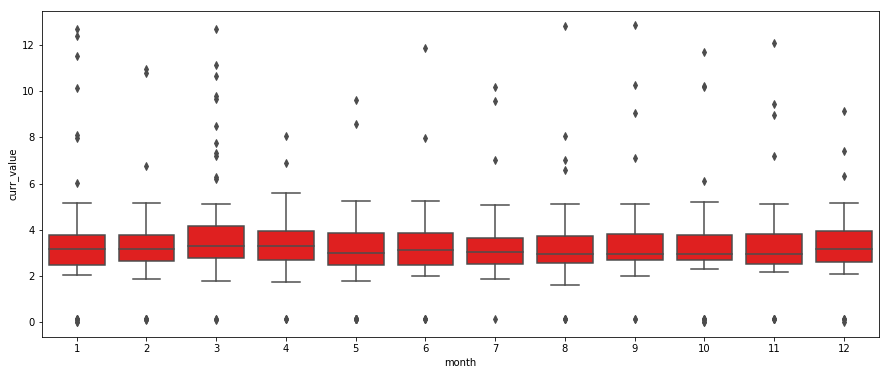

In [162]:
import seaborn as sns

ax = sns.boxplot(x="month", y="curr_value", data=df,color="red")
#ax = sns.swarmplot(x="Month", y="curr_value", data=df_year, color=".25")

We can see some pretty obvious outliers in Month 1 and 6

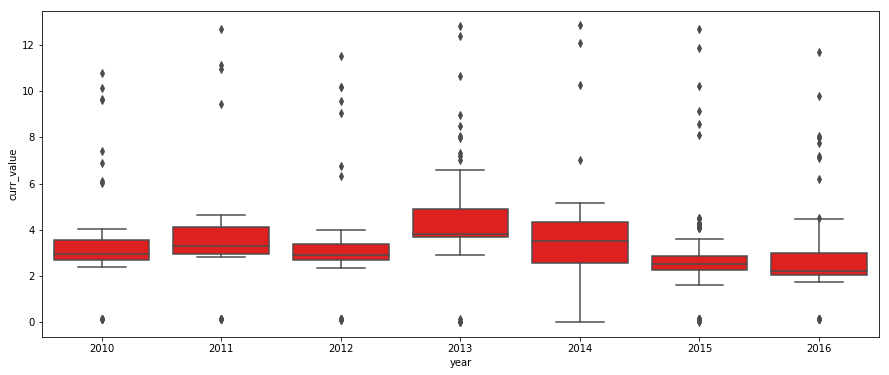

In [163]:
ax = sns.boxplot(x="year", y="curr_value", data=df,color="red")

The visualization neatly describes the anomalous features each year

Like Discussed earlier, only the date, geo and the curr_value fields are relevant with respect to the anomaly detection and hence only including those

In [164]:
df_corr = df.corr()
print(df_corr)

                 year     month       geo  product_sk  currency_sk  \
year         1.000000 -0.062114 -0.024942         NaN     0.989353   
month       -0.062114  1.000000 -0.007585         NaN     0.083284   
geo         -0.024942 -0.007585  1.000000         NaN    -0.025655   
product_sk        NaN       NaN       NaN         NaN          NaN   
currency_sk  0.989353  0.083284 -0.025655         NaN     1.000000   
curr_value  -0.096960 -0.017148  0.274930         NaN    -0.099347   
lag_value         NaN       NaN       NaN         NaN          NaN   
Actual       0.027145 -0.033063 -0.042080         NaN     0.022816   

             curr_value  lag_value    Actual  
year          -0.096960        NaN  0.027145  
month         -0.017148        NaN -0.033063  
geo            0.274930        NaN -0.042080  
product_sk          NaN        NaN       NaN  
currency_sk   -0.099347        NaN  0.022816  
curr_value     1.000000        NaN  0.237785  
lag_value           NaN        NaN      

In [166]:
from sklearn import preprocessing
df = df.dropna()
df_new = df[["geo","curr_value","currency_sk"]]
#df_new = df["curr_value"]
min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df_new)
df_scaled = pd.DataFrame(df_scaled)
df_scaled = df_scaled.astype('float32')

In [167]:
len(df_scaled)

1414

Resizing the array for training autoencoder neural network 

In [168]:
array = np.array(df_scaled)
row,column = array.shape
array = array.reshape((1,row,column))

In [169]:
array.shape

(1, 1414, 3)

In [170]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = column  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(row,column))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(column, activation='sigmoid')(encoded)
#rps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)
encoder = Model(inputs=input, outputs=encoded)

Using TensorFlow backend.


In [171]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=array.shape[1:])
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mse')

In [172]:
# Just compute the distance before learning (show be very bad !)

test_encode = encoder.predict(array)
test_decode = decoder.predict(test_encode)
test_encode = test_encode.reshape((row,column))
test_decode = test_decode.reshape((row,column))
test_array = array.reshape((row,column))
naivedist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    naivedist[i] = np.linalg.norm(x-test_decode[i]) 

In [173]:
df["naivedist"] = naivedist

In [174]:
autoencoder.fit(array, array,
                epochs=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

In [175]:
encoded = encoder.predict(array)
decoded = decoder.predict(encoded)

In [176]:
encoded = encoded.reshape((row,column))
decoded = decoded.reshape((row,column))
array = array.reshape((row,column))


In [177]:
dist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    dist[i] = np.linalg.norm(x-decoded[i]) 

In [178]:
df["dist"] = dist

In [179]:
df_index = df.sort(columns="curr_value")
df_index = df_index.reset_index()
df_index = df_index[["index","curr_value"]]

In [180]:
def mad_based_outlier(points, thresh=4):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D8., Editor.
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh

def doubleMADsfromMedian(y,thresh=4):
    # warning: this function does not check for NAs
    # nor does it address issues when 
    # more than 50% of your data have identical values
    m = np.median(y)
    abs_dev = np.abs(y - m)
    left_mad = np.median(abs_dev[y <= m])
    right_mad = np.median(abs_dev[y >= m])
    y_mad = left_mad * np.ones(len(y))
    y_mad[y > m] = right_mad
    modified_z_score = 0.6745 * abs_dev / y_mad
    modified_z_score[y == m] = 0
    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=99):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

# Valid Only for Non Stationary time series
def anomaly_detector2(feature,Z=3):
    results = []
    diff_X = []
    index = []
    X= np.sort(feature.curr_value)
    Y = feature[feature.columns[0]]
    for i in range(len(X)):
        if i ==0:
            value = X[i]
        else:
            value = X[i] - X[i-1]
                
        diff_X.append(value)
    X_mean = np.mean(diff_X)
    X_std = np.std(diff_X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    j = 0
    for i in diff_X:
        if X_upper < i or X_lower > i:
            results.append(True)
            index.append(Y[j])
        else:
            results.append(False)
        j = j + 1
    return results,index

# Model for stationary time series
def anomaly_detector1(feature,Z=3):
    results = []
    X= np.sort(feature)
    X_mean = np.mean(X)
    X_std = np.std(X)
    X_upper = X_mean + X_std*Z
    X_lower = X_mean - X_std*Z
    for i in feature:
        if X_upper < i or X_lower > i:
            results.append(True)
        else:
            results.append(False)
    return results


In [181]:
results_mad_AE = mad_based_outlier(dist)
results_mad_Normal = mad_based_outlier(df.curr_value)
results_per = percentile_based_outlier(df.curr_value)
results_per_AE = percentile_based_outlier(dist)
results_doublemad_AE = doubleMADsfromMedian(dist)
results_doublemad_Normal = doubleMADsfromMedian(df.curr_value)
results_AD = anomaly_detector1(df.curr_value)
results_AD_AE = anomaly_detector1(dist)

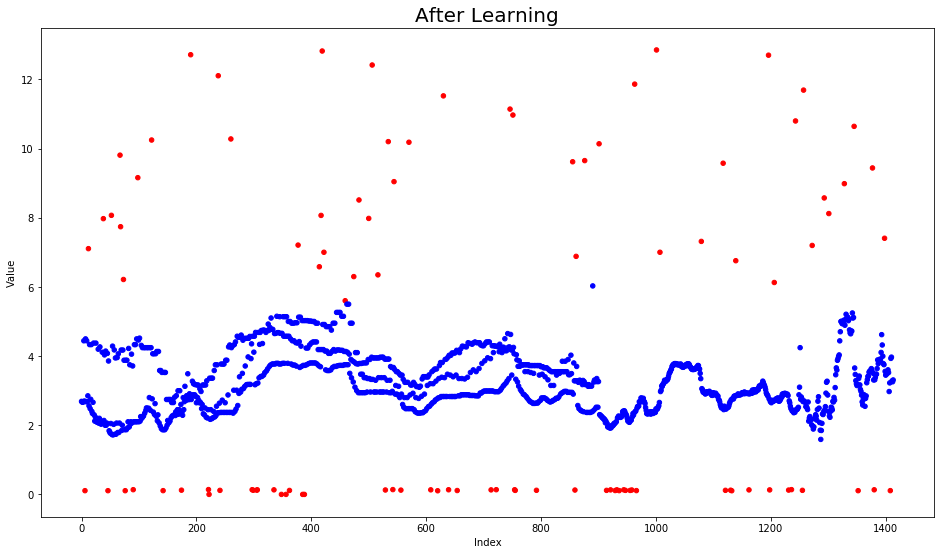

In [182]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_mad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

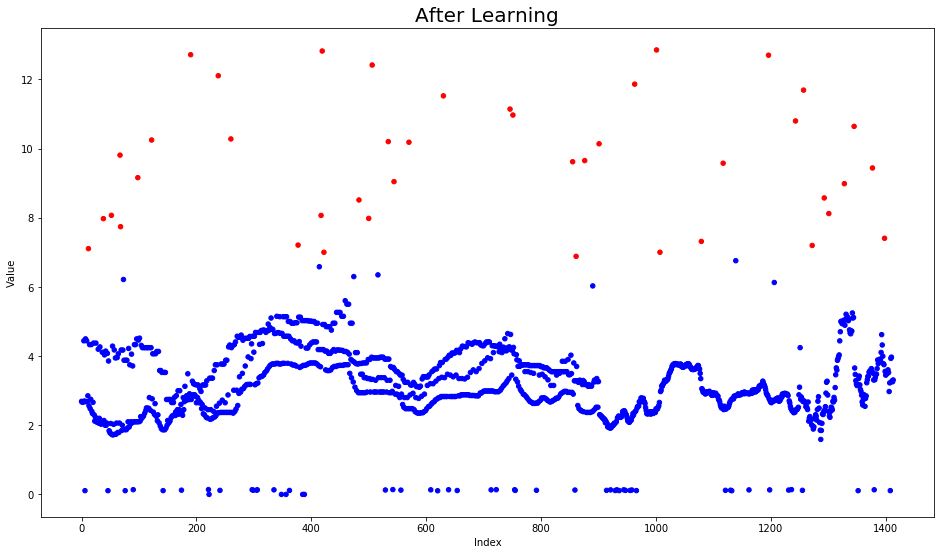

In [183]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_mad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

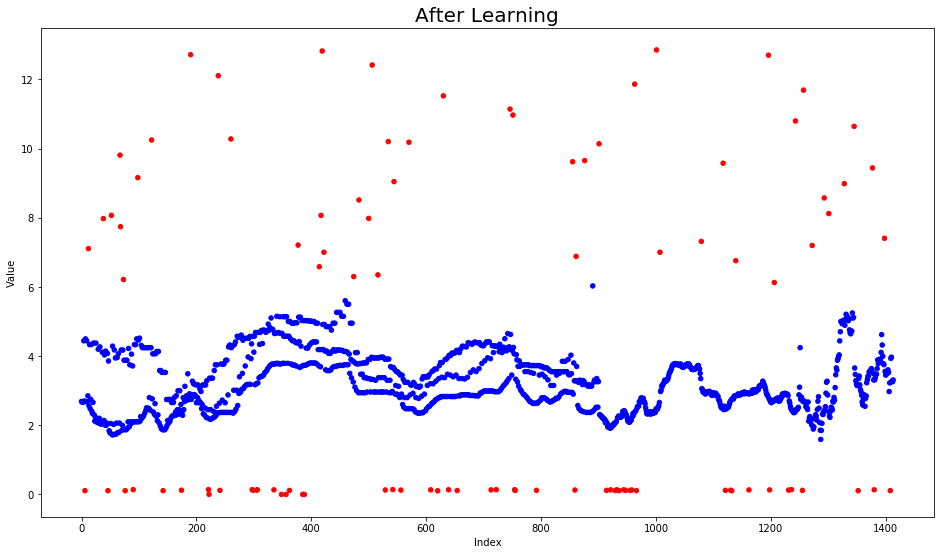

In [184]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_doublemad_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

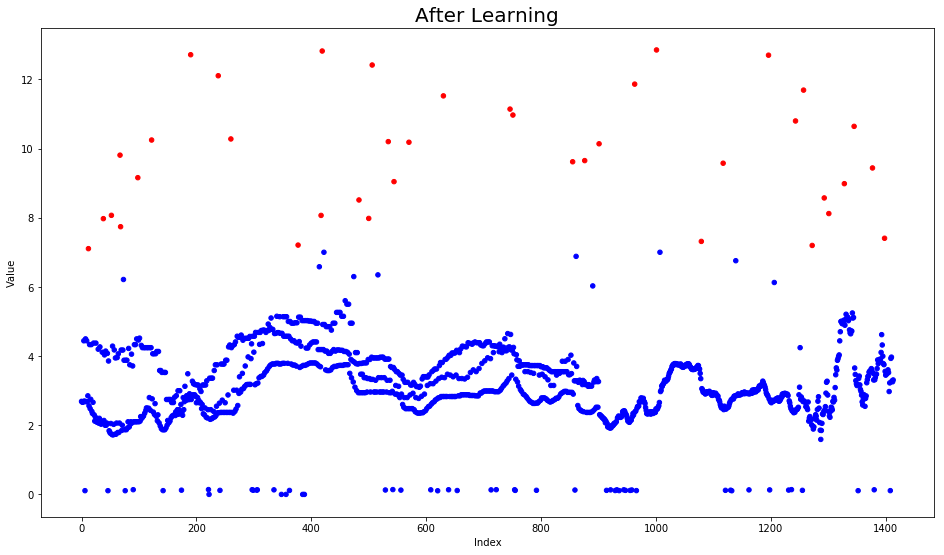

In [185]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_doublemad_Normal], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

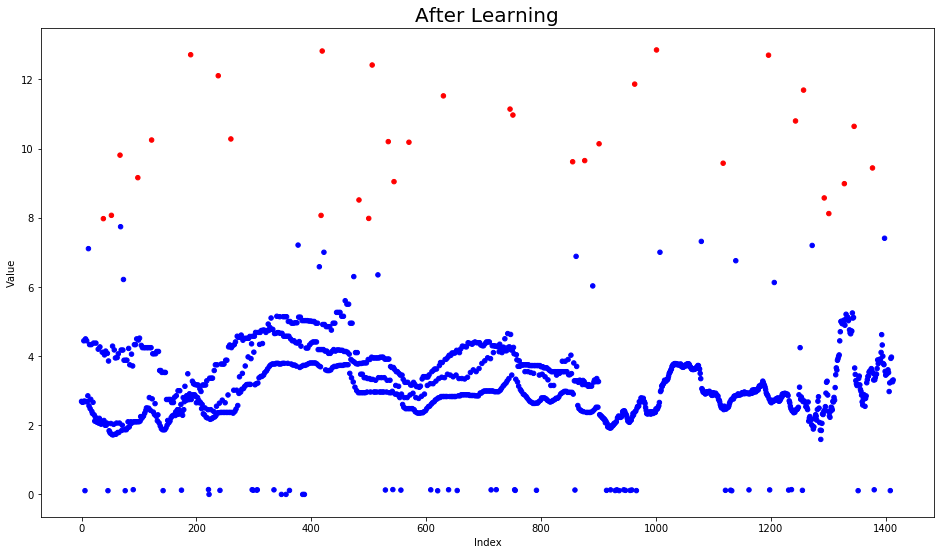

In [186]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_AD], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

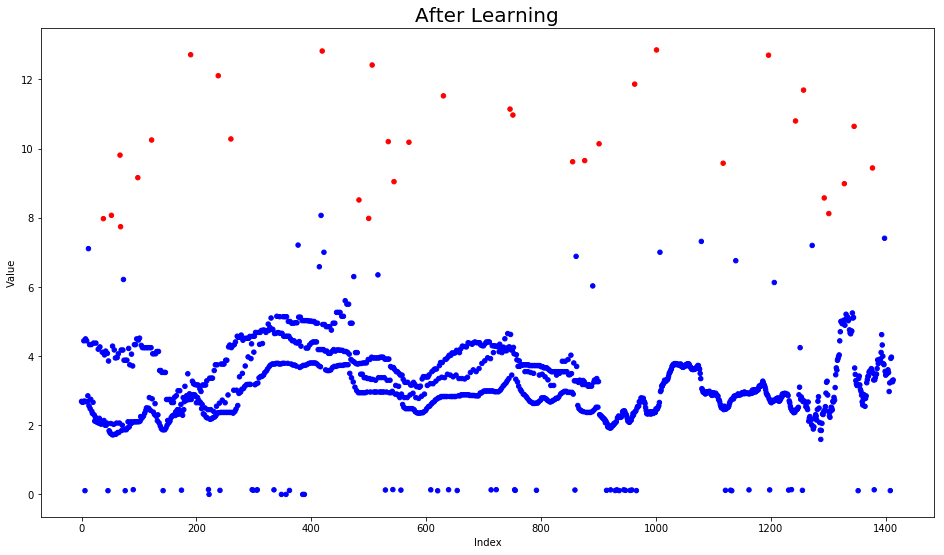

In [187]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_AD_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

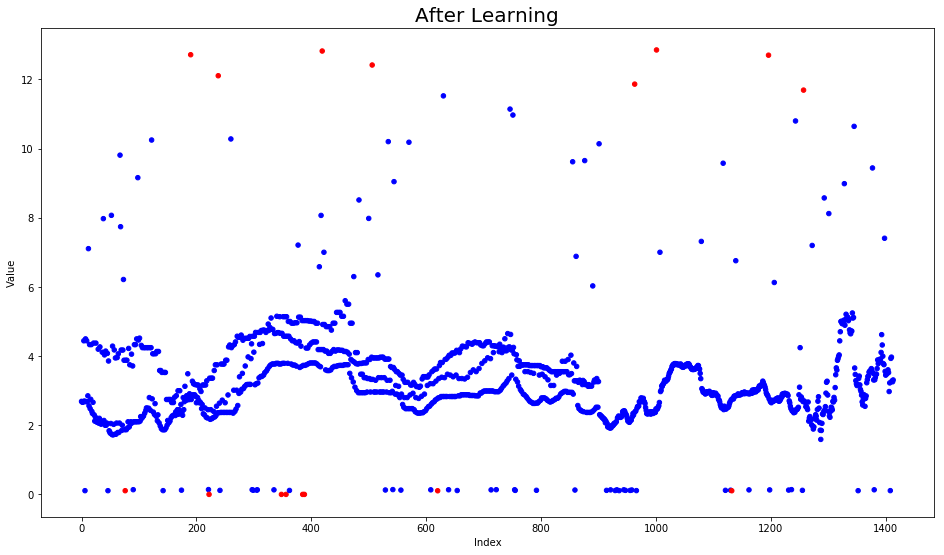

In [188]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_per], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

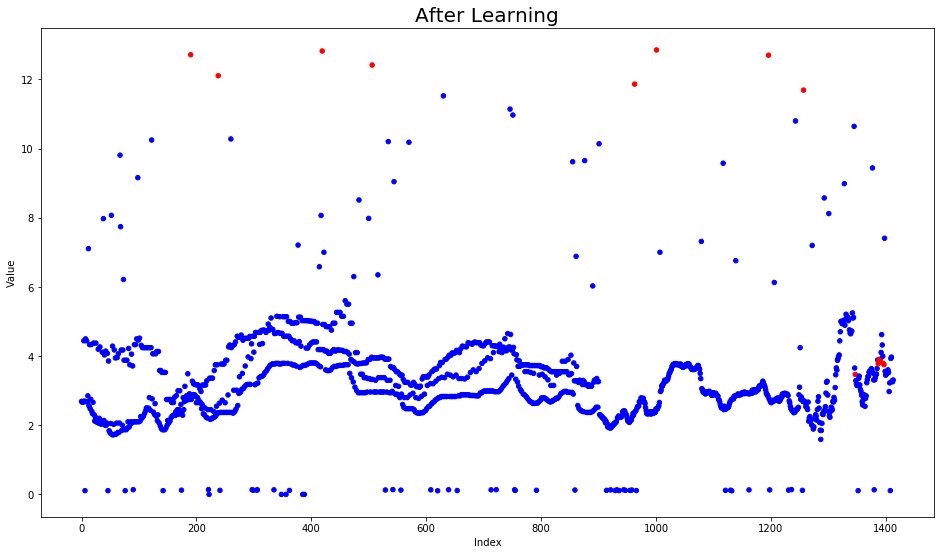

In [189]:

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in results_per_AE], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")

In [190]:
df["Outlier_MAD_AE"] = results_mad_AE
df["Outlier_MAD_Normal"] = results_mad_Normal 
df["Outlier_PER"] = results_per
df["Outlier_PER_AE"] = results_per_AE
df["Outlier_DoubleMAD_AE"] = results_doublemad_AE
df["Outlier_DoubleMAD_Normal"] = results_doublemad_Normal
df["Outlier_AD"] = results_AD
df["Outlier_AD_AE"] = results_AD_AE

In [196]:
cm=confusion_matrix(df.Actual,df.Outlier_MAD_AE)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_MAD_AE)))
print("\n")

cm=confusion_matrix(df.Actual,df.Outlier_MAD_Normal)
print("Accuracy of MAD based Outlier detection using Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection using Autoencoders is :"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_MAD_Normal)))

Accuracy of MAD based Outlier detection using Autoencoders is :0.99504950495
Precision of MAD based Outlier detection using Autoencoders is :0.989690721649
Cohen's Kappa: 0.962163319291


Accuracy of MAD based Outlier detection using Autoencoders is :0.961103253182
Precision of MAD based Outlier detection using Autoencoders is :0.432989690722
Cohen's Kappa: 0.587203685814


In [197]:
cm=confusion_matrix(df.Actual,df.Outlier_DoubleMAD_AE)
print("Accuracy of Double MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_DoubleMAD_AE)))
print("\n")
cm=confusion_matrix(df.Actual,df.Outlier_DoubleMAD_Normal)
print("Accuracy of MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_DoubleMAD_Normal)))

Accuracy of MAD based Outlier detection without Autoencoders is :0.995756718529
Precision of MAD based Outlier detection without Autoencoders is:0.989690721649
Cohen's Kappa: 0.967416602017


Accuracy of MAD based Outlier detection without Autoencoders is :0.958981612447
Precision of MAD based Outlier detection without Autoencoders is:0.40206185567
Cohen's Kappa: 0.55606318137


In [200]:
cm=confusion_matrix(df.Actual,df.Outlier_AD_AE)
print("Accuracy of MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_AD_AE)))
print("\n")
cm=confusion_matrix(df.Actual,df.Outlier_AD)
print("Accuracy of AD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of AD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_AD)))

Accuracy of MAD based Outlier detection without Autoencoders is :0.954738330976
Precision of MAD based Outlier detection without Autoencoders is:0.340206185567
Cohen's Kappa: 0.489927741266


Accuracy of AD based Outlier detection without Autoencoders is :0.954738330976
Precision of AD based Outlier detection without Autoencoders is:0.340206185567
Cohen's Kappa: 0.489927741266


In [194]:
cm=confusion_matrix(df.Actual,df.Outlier_PER_AE)
print("Accuracy of MAD based Outlier detection without Autoencoders is :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of MAD based Outlier detection without Autoencoders is:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))
print("Cohen's Kappa: "+str(cohen_kappa_score(df.Actual,df.Outlier_PER_AE)))

Accuracy of MAD based Outlier detection without Autoencoders is :0.931400282885
Precision of MAD based Outlier detection without Autoencoders is:0.0824742268041
Cohen's Kappa: 0.124586732024


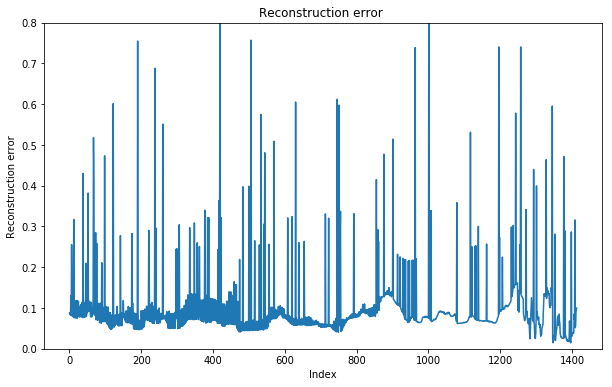

In [202]:
plt.figure(figsize=(10,6))
plt.plot(dist)
#plt.xlim((0,100))
plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error ")

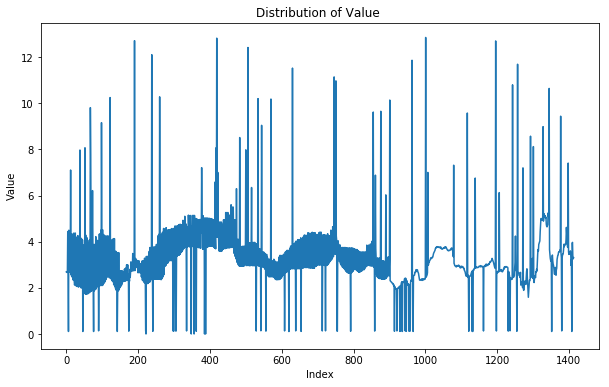

In [203]:
value = np.array(df["curr_value"])
plt.figure(figsize=(10,6))
plt.plot(value)

#plt.xlim((0,1000))
#plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("Distribution of Value ")

In [204]:
df_new.head()

,geo,curr_value,currency_sk
0,1,2.6900,408954
1,1,2.6700,408888
2,1,2.6700,408822
3,1,2.6700,408756
4,4,4.4411,408690


In [219]:
df = pd.read_csv("fact_price_weekly_wmp.csv")
df["geo"] = df["geo"].astype('category').cat.codes
df_new = df[["geo","curr_value","currency_sk"]]
df_new.curr_value = df_new.curr_value.fillna(np.mean(df_new.curr_value))

In [223]:
X_test_sub.head()

,geo,curr_value,currency_sk,Actual
0,4,4.308800,405720,False
1,4,0.107767,387240,True
2,3,10.181936,406116,True
3,4,4.408000,397800,False
4,3,3.975000,400638,False


In [224]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import  train_test_split
X_train,X_test = train_test_split(df_new,test_size=0.2)
X_test = X_test.reset_index(drop=True)
X_test["Actual"] = False
for i in Outliers:
    loc = np.random.randint(0, len(X_test))
    #print(X_test.loc[loc,"curr_value"])
    X_test.loc[loc,"curr_value"] = i
    #print(X_test.loc[loc,"curr_value"])
    X_test.loc[loc,"Actual"] = True
    #print(X_test.loc[loc,"Actual"])
X_test_sub = X_test.drop("Actual",axis=1)
#print(X_test)
# fit the model
clf = IsolationForest(max_samples="auto",n_estimators=100,bootstrap=True,contamination=0.01,)
clf.fit(X_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test_sub)

In [225]:
y_pred_test[y_pred_test ==1] = False
y_pred_test[y_pred_test ==-1] = True


In [226]:
from sklearn.metrics import confusion_matrix,roc_curve,auc,cohen_kappa_score
cm=confusion_matrix(X_test.Actual,y_pred_test)

In [227]:
cm

array([[197,   3],
       [  0,  83]])

In [228]:
coh = cohen_kappa_score(X_test.Actual,y_pred_test)
print(coh)

0.974695240082


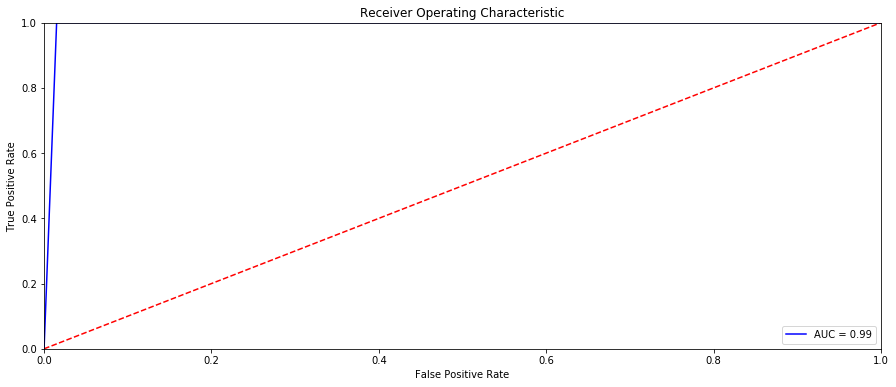

In [229]:
fpr, tpr, threshold = roc_curve(X_test.Actual,y_pred_test)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [230]:
print("Accuracy of Isolation Forest :"+str(float(cm[0][0]+cm[1][1])/((cm[0][0]+cm[1][1])+cm[0][1]+cm[1][0])))
print("Precision of Isolation Forest:"+str(float(cm[1][1])/(cm[1][1]+cm[1][0])))

Accuracy of Isolation Forest :0.989399293286
Precision of Isolation Forest:1.0


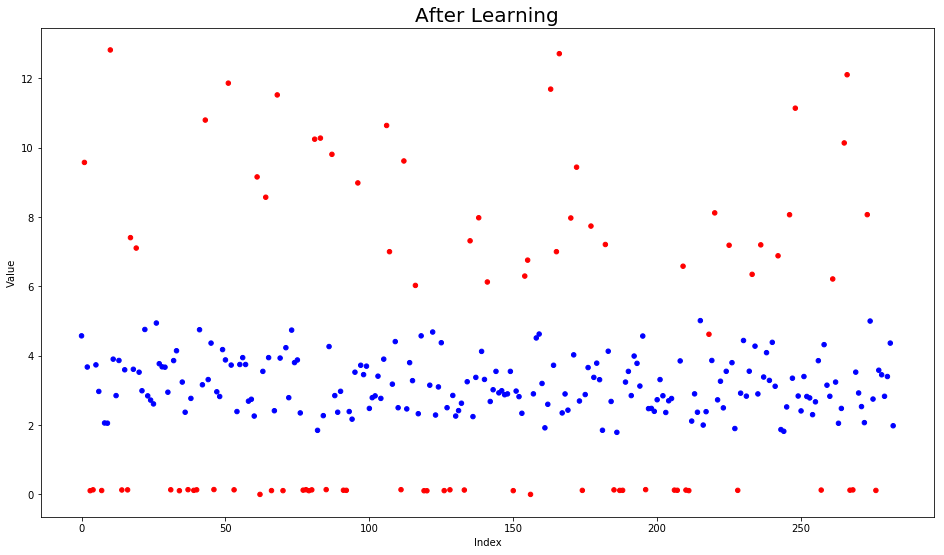

In [233]:
plt.figure(figsize=(16,9))
plt.scatter(X_test.index, X_test["curr_value"], c=[use_colours[x] for x in y_pred_test], s=20)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")